# Installing the required libraries

In [16]:
#!pip install geonamescache

# Importing the Libraries

In [17]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from math import asin
from unidecode import unidecode
from geonamescache import GeonamesCache

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

gc = GeonamesCache()

# Loading the headlines data

In [18]:
headline_file = open('../datasets/headlines.txt','r')
headlines = [line.strip() for line in headline_file.readlines()]
print(f'{len(headlines)} headlines has been loaded from directory')

650 headlines has been loaded from directory


In [19]:
def name_to_regex(name):
    decoded_name = unidecode(name)
    if name != decoded_name:
        regex = fr'\b({name}|{decoded_name})\b'
    else:
        regex = fr'\b{name}\b'
    return re.compile(regex, flags=re.IGNORECASE)

In [20]:
countries = [country['name'] for country in gc.get_countries().values()]
country_to_name = {name_to_regex(name): name for name in countries}

cities = [city['name'] for city in gc.get_cities().values()]
city_to_name = {name_to_regex(name): name for name in cities}

# Finding location in text

In [21]:
def get_name_in_text(text, dictionary):
    for regex, name in sorted(dictionary.items(), key = lambda x: x[1]):
        if regex.search(text):
            return name
    return None

In [22]:
matched_countries = [get_name_in_text(headline, country_to_name) for headline in headlines]
matched_cities = [get_name_in_text(headline, city_to_name) for headline in headlines]

data = {
    'Headline': headlines,
    'City': matched_cities,
    'Country': matched_countries
}

df = pd.DataFrame(data)
df.head()

Headline           City Country
0                 Zika Outbreak Hits Miami          Miami    None
1          Could Zika Reach New York City?  New York City    None
2        First Case of Zika in Miami Beach          Miami    None
3  Mystery Virus Spreads in Recife, Brazil         Recife  Brazil
4  Dallas man comes down with case of Zika         Dallas    None

In [23]:
df[['City','Country']].describe()

City Country
count   618      15
unique  511      10
top      Of  Brazil
freq     44       3

In [24]:
of_cities = df[df.City == 'Of'][['City','Headline']]
print(of_cities.head(10).to_string(index = False))

City                                                                Headline
  Of                                   Case of Measles Reported in Vancouver
  Of Authorities are Worried about the Spread of Bronchitis in Silver Spring
  Of     Authorities are Worried about the Spread of Mad Cow Disease in Rome
  Of                    Rochester authorities confirmed the spread of Dengue
  Of                          Tokyo Encounters Severe Symptoms of Meningitis
  Of       Authorities are Worried about the Spread of Influenza in Savannah
  Of                                 Spike of Pneumonia Cases in Springfield
  Of                     The Spread of Measles in Spokane has been Confirmed
  Of                                         Outbreak of Zika in Panama City
  Of                         Urbana Encounters Severe Symptoms of Meningitis


In [25]:
def get_cities_in_headline(headline):
    cities_in_headline = set()
    for regex, name in city_to_name.items():
        match = regex.search(headline)
        if match:
            if headline[match.start()].isupper():
                cities_in_headline.add(name)
    return list(cities_in_headline)

df['Cities'] = df['Headline'].apply(get_cities_in_headline)
df['Num_cities'] = df['Cities'].apply(len)
df_multiple_cities = df[df.Num_cities > 1]
num_rows, _ = df_multiple_cities.shape
print(f"{num_rows} headlines match multiple cities")

72 headlines match multiple cities


In [26]:
df.head()

Headline           City Country  \
0                 Zika Outbreak Hits Miami          Miami    None   
1          Could Zika Reach New York City?  New York City    None   
2        First Case of Zika in Miami Beach          Miami    None   
3  Mystery Virus Spreads in Recife, Brazil         Recife  Brazil   
4  Dallas man comes down with case of Zika         Dallas    None   

                  Cities  Num_cities  
0                [Miami]           1  
1  [New York City, York]           2  
2   [Miami, Miami Beach]           2  
3               [Recife]           1  
4               [Dallas]           1

## Sampling multi-cities headlines

In [27]:
ten_cities = df_multiple_cities[['Cities', 'Headline']].head(10)
print(ten_cities.to_string(index = False))

                       Cities                                                   Headline
        [New York City, York]                            Could Zika Reach New York City?
         [Miami, Miami Beach]                          First Case of Zika in Miami Beach
              [San, San Juan] San Juan reports 1st U.S. Zika-related death amid outbreak
   [Los Ángeles, Los Angeles]                       New Los Angeles Hairstyle goes Viral
                 [Bay, Tampa]                      Tampa Bay Area Zika Case Count Climbs
       [Ho Chi Minh City, Ho]             Zika cases in Vietnam's Ho Chi Minh City surge
             [San, San Diego]                   Key Zika Findings in San Diego Institute
          [Hīt, Kuala Lumpur]                         Kuala Lumpur is Hit By Zika Threat
         [San, San Francisco]                           Zika Virus Reaches San Francisco
[San Salvador, Salvador, San]                               Zika worries in San Salvador


Short, invalid city names are getting matched to the headlines along with longer, more correct location names. One solution is simply to assign the longest city-name as the representative location if more than one matched city is found.

In [28]:
def get_longest_city(cities):
    if cities:
        return max(cities, key = len)
    return None
df['City'] = df['Cities'].apply(get_longest_city)

In [29]:
df_countries = df[df.Country.notnull()][['City','Country','Headline']]
print(df_countries.to_string(index = False))

            City   Country                                                              Headline
          Recife    Brazil                               Mystery Virus Spreads in Recife, Brazil
Ho Chi Minh City   Vietnam                        Zika cases in Vietnam's Ho Chi Minh City surge
         Bangkok  Thailand                                        Thailand-Zika Virus in Bangkok
      Piracicaba    Brazil                                   Zika outbreak in Piracicaba, Brazil
           Klang  Malaysia                                      Zika surfaces in Klang, Malaysia
  Guatemala City Guatemala Rumors about Meningitis spreading in Guatemala City have been refuted
     Belize City    Belize                                    Belize City under threat from Zika
        Campinas    Brazil                                      Student sick in Campinas, Brazil
     Mexico City    Mexico                                  Zika outbreak spreads to Mexico City
   Kota Kinabalu  Malaysia    

In [30]:
df.drop('Country', axis = 1, inplace = True)

# Exploring the unmatched headlines

In [31]:
df_unmatched = df[df.City.isnull()]
num_unmatched = len(df_unmatched)
print(f'{num_unmatched} has no city matches')
print(df_unmatched.head(10)[['Headline']].values)

39 has no city matches
[['Louisiana Zika cases up to 26']
 ['Zika infects pregnant woman in Cebu']
 ['Spanish Flu Sighted in Antigua']
 ['Zika case reported in Oton']
 ['Maka City Experiences Influenza Outbreak']
 ['West Nile Virus Outbreak in Saint Johns']
 ['Syphilis Hits Jefferson']
 ['Malaria Exposure in Sussex']
 ['Greenwich Establishes Zika Task Force']
 ['Will West Nile Virus vaccine help Parsons?']]


In [32]:
df = df[~df.City.isnull()][['City','Headline']]

# Visulizing and Clustering the Extracted Location Data

In [33]:
latitide, longitude = [],[]
for city_name in df.City.values:
    city = max(gc.get_cities_by_name(city_name), key = lambda x: list(x.values())[0]['population'])
    city = list(city.values())[0]
    latitide.append(city['latitude'])
    longitude.append(city['longitude'])
df = df.assign(Latitude = latitide, Longitude = longitude)

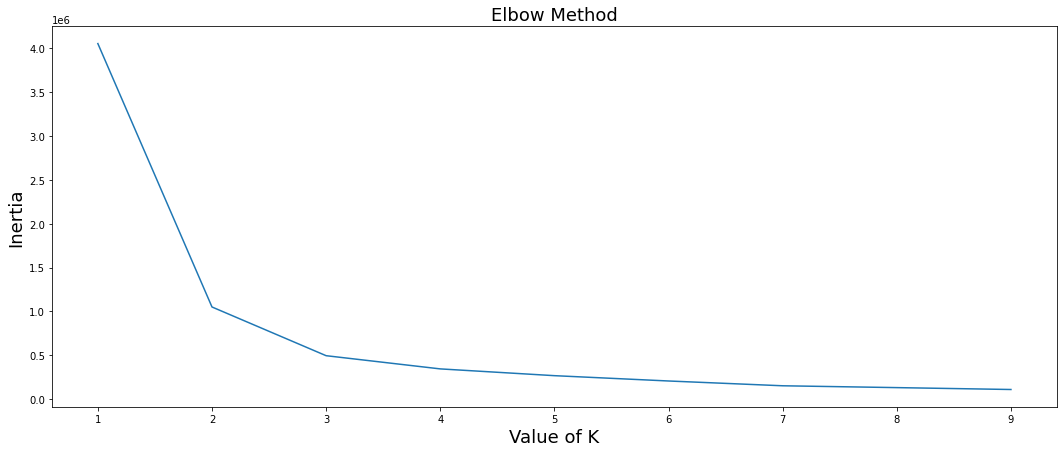

In [34]:
coordinates = df[['Latitude', 'Longitude']].values
k_values = range(1,10)
inertia_values = []

for k in k_values:
    inertia_values.append(KMeans(k).fit(coordinates).inertia_)

plt.figure(figsize=(18,7))
plt.plot(range(1,10), inertia_values)
plt.title('Elbow Method', fontsize = 18)
plt.xlabel('Value of K', fontsize = 18)
plt.ylabel('Inertia', fontsize = 18)
plt.show()

### The "elbow" within our Elbow plot points to a K of 3 That K-value is very low, limiting our scope to at-most 3 different geographic territories

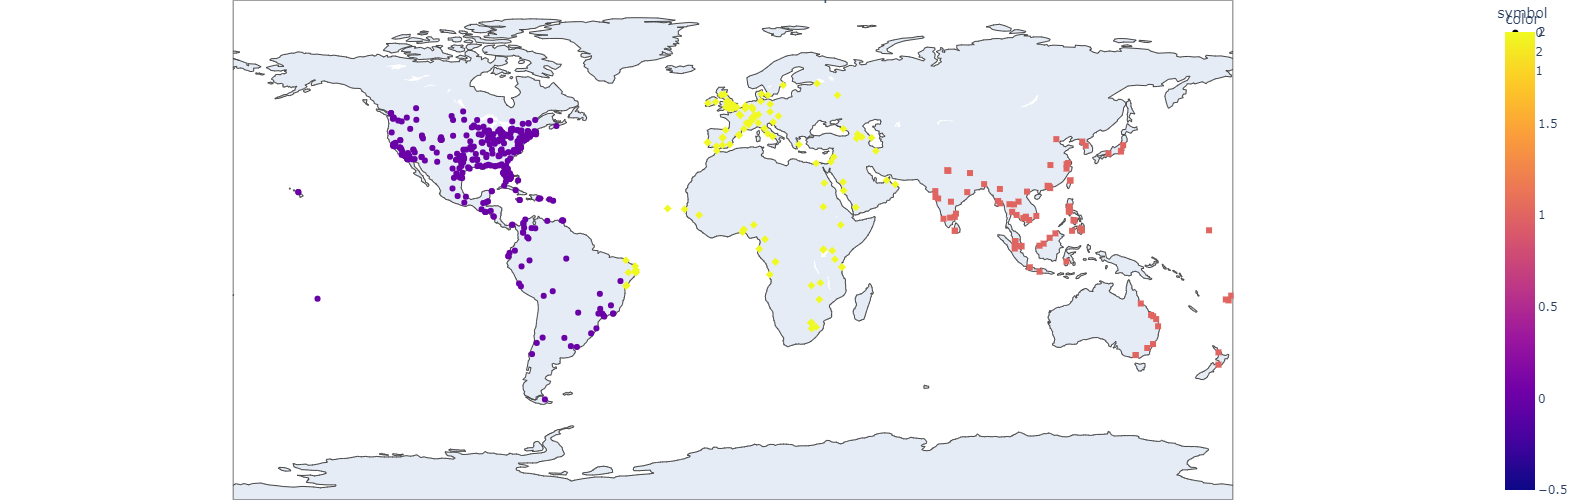

In [35]:
def plot_clusters(clusters, longitude, latitude):
    fig = px.scatter_geo(lat = latitide,lon = longitude, color = clusters, symbol = clusters)
    fig.update_layout(title = 'World map', title_x=0.5)
    fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()

df['Cluster'] = KMeans(3).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

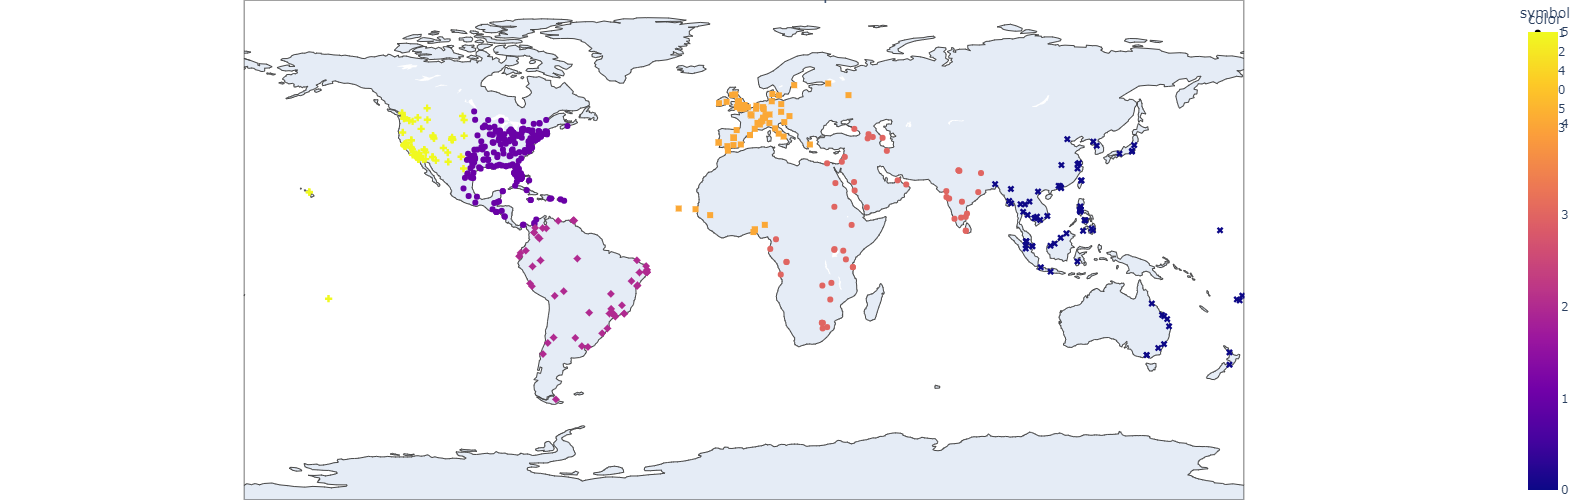

In [36]:
df['Cluster'] = KMeans(6).fit_predict(coordinates)
plot_clusters(df.Cluster, df.Longitude, df.Latitude)

# Using DBSCAN algorithm

In [37]:
def great_circle_distance(coord1, coord2, radius=3956):
    if np.array_equal(coord1, coord2):
        return 0.0 

    coord1, coord2 = np.radians(coord1), np.radians(coord2)
    delta_x, delta_y = coord2 - coord1
    haversin = np.sin(delta_x / 2) ** 2 + np.product([np.cos(coord1[0]),
                                                   np.cos(coord2[0]), 
                                                   np.sin(delta_y / 2) ** 2])
    return  2 * radius * asin(haversin ** 0.5)

In [38]:
metric = great_circle_distance
dbscan = DBSCAN(eps = 250, min_samples = 3, metric = metric)
df['Cluster'] = dbscan.fit_predict(coordinates)

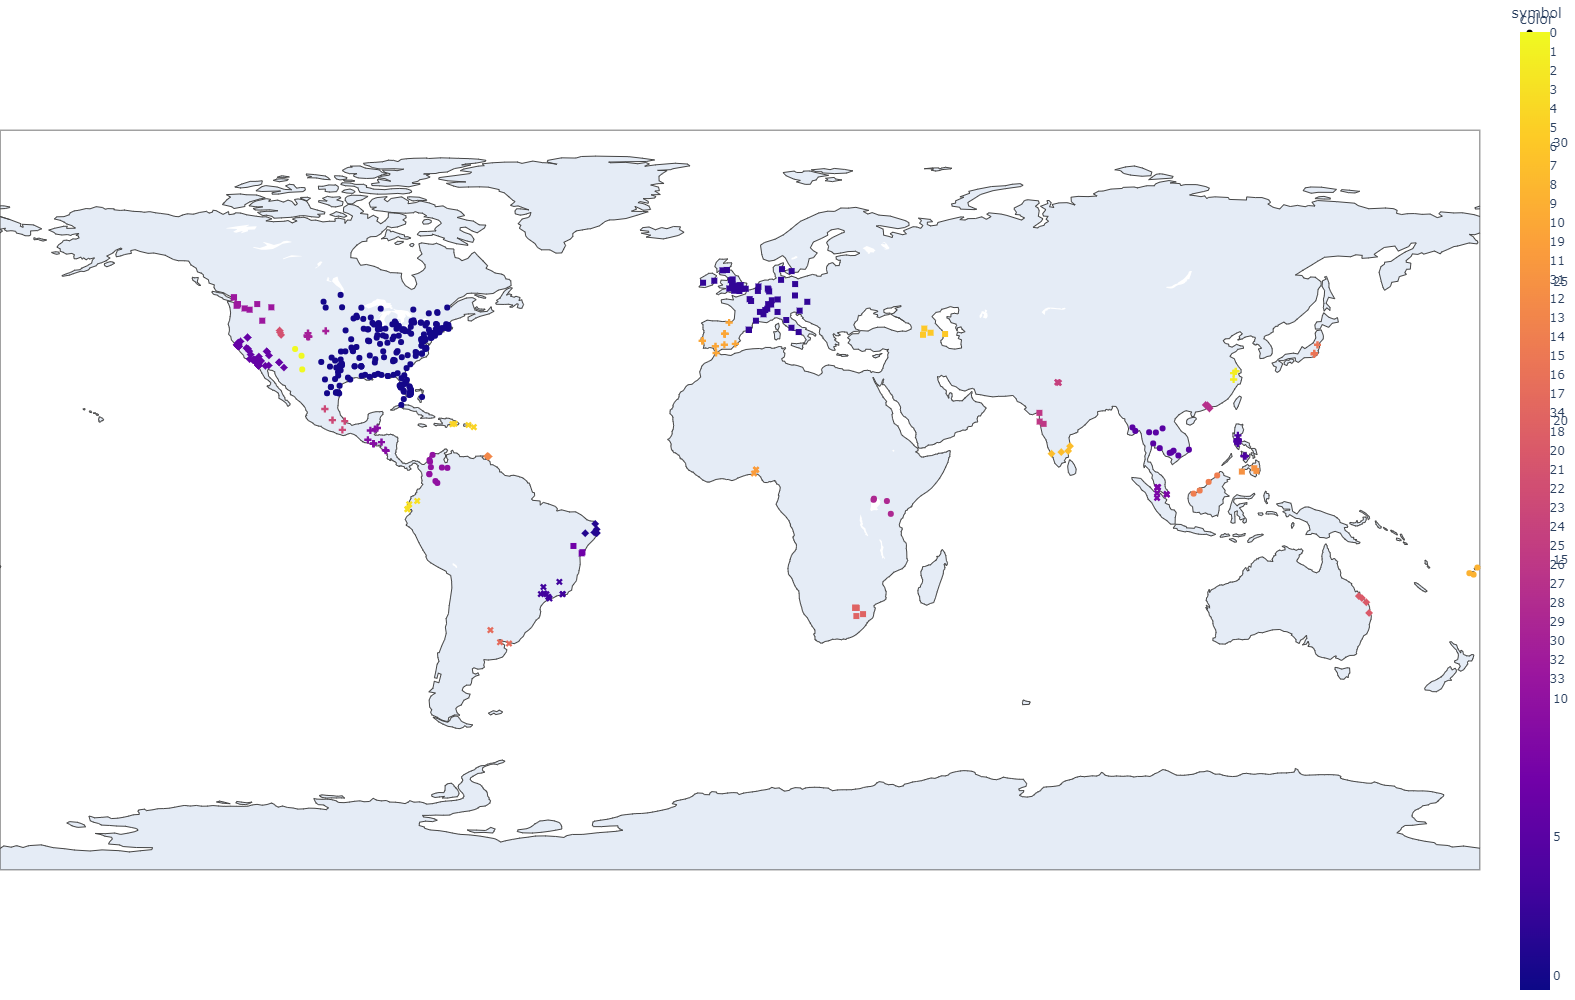

In [39]:
no_outliers = df[df.Cluster > -1]

fig = px.scatter_geo(lat = no_outliers.Latitude ,lon = no_outliers.Longitude, color = no_outliers.Cluster, symbol = no_outliers.Cluster)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Assigning country codes to cities

In [40]:
def get_country_code(city_name):
    city = max(gc.get_cities_by_name(city_name), 
               key=lambda x: list(x.values())[0]['population'])
    return list(city.values())[0]['countrycode']

df['Country_code'] = df.City.apply(get_country_code)

# Seperating the cities and global cities

In [41]:
df_us = df[df.Country_code == 'US']
df_not_us = df[df.Country_code != 'US']

# Re-Clustering the data

In [42]:
def re_cluster(input_df, eps):
    input_coord = input_df[['Latitude','Longitude']].values
    dbscan = DBSCAN(eps = eps, min_samples = 3, metric = great_circle_distance)
    clusters = dbscan.fit_predict(input_coord)
    input_df = input_df.assign(Cluster = clusters)
    return input_df[input_df.Cluster >-1]

df_not_us = re_cluster(df_not_us, 250)
df_us = re_cluster(df_us, 125)

In [43]:
df_not_us

City                                           Headline  Latitude  \
3         Recife            Mystery Virus Spreads in Recife, Brazil  -8.05389   
7         Genève              Geneve Scientists Battle to Find Cure  46.20222   
9      São Paulo                 Zika Infested Monkeys in Sao Paulo -23.54750   
14        Manila                 Zika alert – Manila now threatened  14.60420   
15        Iloilo                     Zika afflicts 7 in Iloilo City  10.69694   
..           ...                                                ...       ...   
639      Sevilla       New medicine wipes out Meningitis in Sevilla  37.38283   
643   Portoviejo                     Outbreak of Zika in Portoviejo  -1.05458   
646       Indang              More Zika patients reported in Indang  14.19528   
647         Suva  Suva authorities confirmed the spread of Rotav... -18.14161   
648  Bella Vista         More Zika patients reported in Bella Vista  18.45539   

     Longitude  Cluster Country_code  
3    -34.88111        0           BR  
7      6.14569        1           CH  
9    -46.63611        2           BR  
14   120.98220        3           PH  
15   122.56444        3           PH  
..         ...      ...          ...  
639   -5.97317       23           ES  
643  -80.45445       29           EC  
646  120.87694        3           PH  
647  178.44149       25           FJ  
648  -69.94540       28           DO  

[216 rows x 6 columns]

In [44]:
df_us

City                                           Headline  \
0            Miami                           Zika Outbreak Hits Miami   
1    New York City                    Could Zika Reach New York City?   
2      Miami Beach                  First Case of Zika in Miami Beach   
4           Dallas            Dallas man comes down with case of Zika   
8          Atlanta              The CDC in Atlanta is Growing Worried   
..             ...                                                ...   
637         Easton                          Dengue Outbreak in Easton   
640         Clovis  Authorities are Worried about the Spread of Va...   
641     Fort Worth          More Zika patients reported in Fort Worth   
642  Boynton Beach             Zika symptoms spotted in Boynton Beach   
649  Wichita Falls                     Zika Outbreak in Wichita Falls   

     Latitude  Longitude  Cluster Country_code  
0    25.77427  -80.19366        0           US  
1    40.71427  -74.00597        1           US  
2    25.79065  -80.13005        0           US  
4    32.78306  -96.80667        2           US  
8    33.74900  -84.38798        1           US  
..        ...        ...      ...          ...  
637  40.68843  -75.22073        1           US  
640  36.82523 -119.70292        5           US  
641  32.72541  -97.32085        2           US  
642  26.52535  -80.06643        0           US  
649  33.91371  -98.49339        2           US  

[281 rows x 6 columns]

# Extracting the insights from clusters

In [45]:
# Grouping cities by clusters 
groups = df_not_us.groupby('Cluster')
print(f'{len(groups)} Non-US clusters have been detected')

31 Non-US clusters have been detected


In [46]:
sorted_groups = sorted(groups, key = lambda x: len(x[1]), reverse=True)
group_id, largest_group = sorted_groups[0]

group_size = len(largest_group)
print(f'Largest clusters contains {group_size} headlines')

Largest clusters contains 51 headlines


# Computing the cluster centrality

In [47]:
def compute_centrality(group):
    group_coords = group[['Latitude', 'Longitude']].values
    center = group_coords.mean(axis = 0)
    distance_to_center = [great_circle_distance(center, coord) for coord in group_coords]
    group['Distance_to_center'] = distance_to_center  

In [48]:
def sort_by_centrality(group):
    compute_centrality(group)
    return group.sort_values(by = ['Distance_to_center'], ascending = True)

largest_group = sort_by_centrality(largest_group)
for headline in largest_group.Headline.values[:5]:
    print(headline)

Mad Cow Disease Disastrous to Brussels
Scientists in Paris to look for answers
More Livestock in Fontainebleau are infected with Mad Cow Disease
Mad Cow Disease Hits Rotterdam
Contaminated Meat Brings Trouble for Bonn Farmers


# Finding the top three countries in the largest cluster

In [49]:
from collections import Counter

def top_countries(group):
    countries = [gc.get_countries()[country_code]['name'] for country_code in group.Country_code.values]
    return Counter(countries).most_common(3)

print(top_countries(largest_group))

[('United Kingdom', 19), ('France', 7), ('Germany', 6)]


In [50]:
for _, group in sorted_groups[1:5]:
    sorted_group = sort_by_centrality(group)
    print(top_countries(sorted_group))
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

[('Philippines', 15)]
Zika afflicts patient in Calamba
Hepatitis E re-emerges in Santa Rosa
Batangas Tourism Takes a Hit as Virus Spreads
More Zika patients reported in Indang
Spreading Zika reaches Bacoor


[('Thailand', 5), ('Cambodia', 3), ('Vietnam', 2)]
More Zika patients reported in Chanthaburi
Thailand-Zika Virus in Bangkok
Zika case reported in Phetchabun
Zika arrives in Udon Thani
More Zika patients reported in Kampong Speu


[('Spain', 8), ('Portugal', 2), ('Morocco', 1)]
Spanish flu spreading in Madrid
Rabies Hits Madrid
Spanish Flu Spreading through Madrid
Spanish Flu Spreading through Madrid
Zika Troubles come to Jaen


[('El Salvador', 3), ('Guatemala', 2), ('Belize', 2)]
Zika Reported in Ilopango
More Zika cases in Soyapango
Zika worries in San Salvador
Zika arrives in Tegucigalpa
Rumors about Meningitis spreading in Guatemala City have been refuted




# Plotting DBSCAN cluster

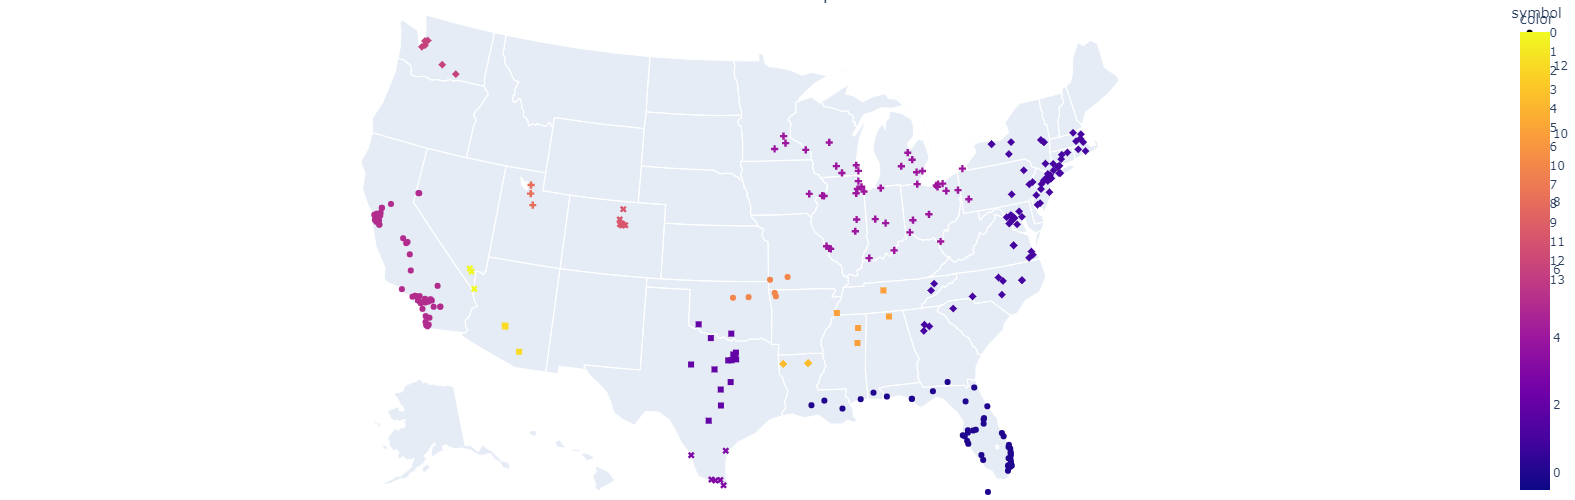

In [51]:
fig = px.scatter_geo(lat = df_us.Latitude,lon = df_us.Longitude, color = df_us.Cluster , symbol = df_us.Cluster, scope = 'usa')
fig.update_layout(title = 'World map', title_x=0.5)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Summarizing content within the largest US clusters

In [52]:
us_groups = df_us.groupby('Cluster')
us_sorted_groups = sorted(us_groups, key = lambda x: len(x[1]), reverse = True)

for _, group in us_sorted_groups[:5]:
    sorted_group = sort_by_centrality(group)
    for headline in sorted_group.Headline.values[:5]:
        print(headline)
    print('\n')

Schools in Bridgeton Closed Due to Mumps Outbreak
Philadelphia experts track pandemic
Vineland authorities confirmed the spread of Chlamydia
Baltimore plans for Zika virus
Will Swine Flu vaccine help Annapolis?


Bradenton Experiences Zika Troubles
New Zika Case Confirmed in Sarasota County
Tampa Bay Area Zika Case Count Climbs
Zika Strikes St. Petersburg
Zika spreads to Plant City


Rhinovirus Hits Bakersfield
Schools in Tulare Closed Due to Mumps Outbreak
New medicine wipes out West Nile Virus in Ventura
New medicine wipes out Measles in Fresno
Authorities are Worried about the Spread of Varicella in Clovis


How to Avoid Hepatitis E in South Bend
Hepatitis E Hits Hammond
Chicago's First Zika Case Confirmed
Rumors about Hepatitis C spreading in Darien have been refuted
Rumors about Rotavirus Spreading in Joliet have been Refuted


More Zika patients reported in Fort Worth
Outbreak of Zika in Stephenville
Zika symptoms spotted in Arlington
Dallas man comes down with case of Zika
Zika 

# Plotting Zika clusters

In [53]:
def count_zika_mention(headlines):
    zika_regex = re.compile(r'\bzika\b', flags = re.IGNORECASE)
    zika_count = 0
    
    for headline in headlines:
        if zika_regex.search(headline):
            zika_count += 1
    return zika_count

In [54]:
zika_longitude = []
zika_latitude = []
zika_cluster = []
zika_headline = []

for _, group in sorted_groups + us_sorted_groups:
    headlines = group.Headline.values
    zika_count = count_zika_mention(headlines)
    if float(zika_count) / len(headlines) > 0.5:
        zika_longitude.append(list(group.Longitude.values))
        zika_latitude.append(list(group.Latitude.values))
        zika_cluster.append(list(group.Cluster.values))
        zika_headline.append(list(group.Headline.values))
        

In [55]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [56]:
zika_longitude = flatten(zika_longitude)
zika_latitude = flatten(zika_latitude)
zika_cluster = flatten(zika_cluster)

In [57]:
zika_df = pd.DataFrame({
    'Longitude': zika_longitude,
    'Latitude': zika_latitude,
    'Cluster': zika_cluster
})

zika_df.head()

Longitude  Latitude  Cluster
0  120.98220  14.60420        3
1  122.56444  10.69694        3
2  121.04090  14.58320        3
3  121.11139  14.31222        3
4  121.05090  14.64880        3

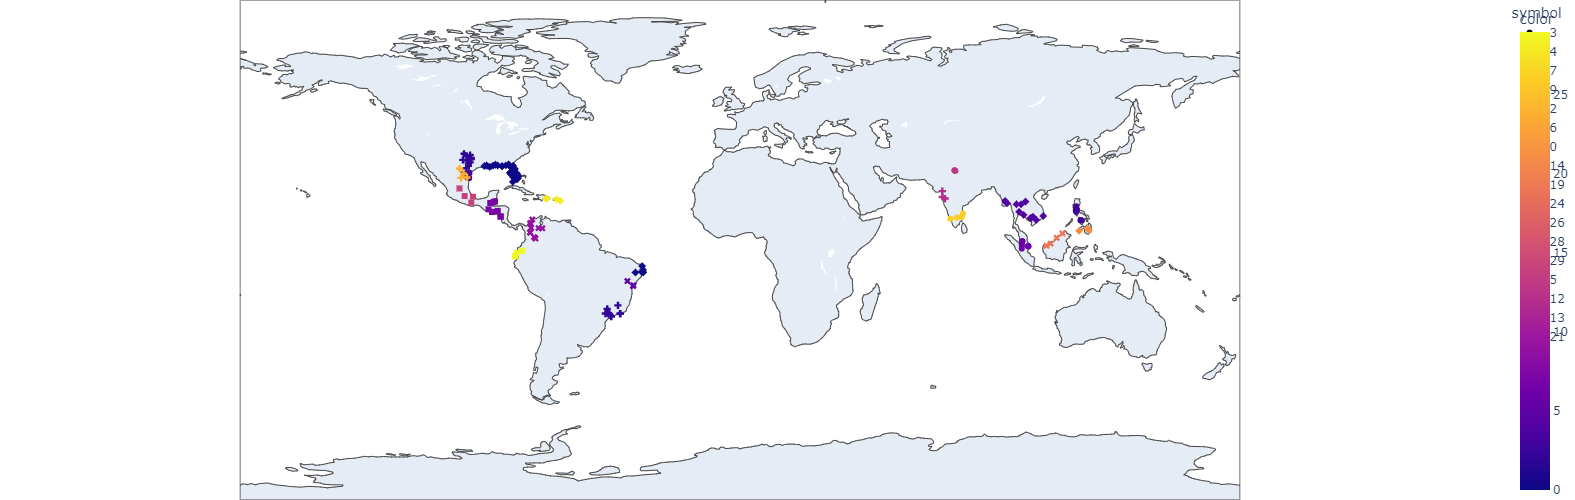

In [58]:
fig = px.scatter_geo(lat = zika_df.Latitude,lon = zika_df.Longitude, color = zika_df.Cluster , symbol = zika_df.Cluster)
fig.update_layout(title = 'World map', title_x=0.5)
fig.update_layout(height=500, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()